In [1]:
# %pip install fastcluster
# %pip install joblib

# Cointegration Tests & Pairs Trading

## What is cointegration?
We have seen how a time series can have a unit root that creates a stochastic trend and makes the time series highly persistent. When we use such an integrated time series in their original, rather than in differenced, form as a feature in a linear regression model, its relationship with the outcome will often appear statistically significant, even though it is not. This phenomenon is called spurious regression (for details, see Chapter 18 in [Wooldridge, 2008](https://economics.ut.ac.ir/documents/3030266/14100645/Jeffrey_M._Wooldridge_Introductory_Econometrics_A_Modern_Approach__2012.pdf)). Therefore, the recommended solution is to difference the time series so they become stationary before using them in a model.

However, there is an exception when there are cointegration relationships between the outcome and one or more input variables. To understand the concept of cointegration, let's first remember that the residuals of a regression model are a linear combination of the inputs and the output series.

Usually, the residuals of the regression of one integrated time series on one or more such series yields non-stationary residuals that are also integrated, and thus behave like a random walk. However, for some time series, this is not the case: the regression produces coefficients that yield a linear combination of the time series in the form of the residuals that are stationary, even though the individual series are not. Such time series are
cointegrated.

A non-technical example is that of a drunken man on a random walk accompanied by his dog (on a leash). Both trajectories are non-stationary but cointegrated because the dog will occasionally revert to his owner. In the trading context, arbitrage constraints imply cointegration between spot and futures prices.

In other words, a linear combination of two or more cointegrated series has a stable mean to which this linear combination reverts. This also applies when the individual series are integrated of a higher order and the linear combination reduces the overall order of integration.

Cointegration differs from correlation: two series can be highly correlated but need not be cointegrated. For example, if two growing series are constant multiples of each other, their correlation will be high, but any linear combination will also grow rather than revert to a stable mean.

## Cointegration for Pairs Trading

Cointegration is very useful: if two or more asset price series tend to revert to a common mean, we can leverage deviations from the trend because they should imply future price moves in the opposite direction. The mathematics behind cointegration is more involved, so we will only focus on the practical aspects; for an in-depth treatment, see [Lütkepohl (2005)](https://www.springer.com/gp/book/9783540401728).

In this notebook, we will address how we can identify pairs with such a long-term stationary relationship, estimate the expected time for any disequilibrium to correct, and how to utilize these tools to implement and backtest a long-short pairs trading strategy. There are two approaches to testing for cointegration:
- The Engle-Granger two-step method
- The Johansen test

The book chapter discusses each test in turn; in this notebook we show how they help identify cointegrated securities that tend to revert to a common trend, a fact that we can leverage for a statistical arbitrage
strategy.

## Imports & Settings

In [2]:
# import warnings
# warnings.filterwarnings('ignore')

In [3]:
from time import time
from pathlib import Path
from tqdm import tqdm 

import numpy as np
from numpy.linalg import LinAlgError
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.tree import  DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV

from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR

import matplotlib.pyplot as plt
import seaborn as sns

from joblib import Parallel, delayed

In [4]:
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')


In [5]:
DATA_PATH = Path('..', 'data')
STORE = DATA_PATH / 'assets.h5'

### Johansen Test Critical Values

These critical values for the Johansen trace statistic are sourced from the tables in Osterwald-Lenum (1992), "A Note with Quantiles of the Asymptotic Distribution of the Maximum Likelihood Cointegration Rank Test Statistics," published in the Oxford Bulletin of Economics and Statistics (Volume 54, Issue 3, pages 461-472). They correspond to the case with a constant term but no linear trend (det_order=0 in statsmodels), for a bivariate system (two variables), at the 90%, 95%, and 99% significance levels:

- For testing 0 cointegration relationships (rank 0): 13.4294 (90%), 15.4943 (95%), 19.9349 (99%).
- For testing 1 cointegration relationship (rank 1): 2.7055 (90%), 3.8415 (95%), 6.6349 (99%).

These values are commonly hardcoded or referenced in implementations like statsmodels' `coint_johansen` function, which draws from this paper for systems with fewer variables.

In [6]:
critical_values = {0: {.9: 13.4294, .95: 15.4943, .99: 19.9349},
                   1: {.9: 2.7055, .95: 3.8415, .99: 6.6349}}

In [7]:
trace0_cv = critical_values[0][.95] # critical value for 0 cointegration relationships
trace1_cv = critical_values[1][.95] # critical value for 1 cointegration relationship

## Load & Clean Stock & ETF Data

### Remove highly correlated assets

A function removes highly correlated assets (correlation > 0.99) to avoid redundancy:

It computes the correlation matrix, identifies pairs above the cutoff, and decides which to keep/drop to minimize duplicates.

In [8]:
def remove_correlated_assets(df, cutoff=.99):
    corr = df.corr().stack()
    corr = corr[corr < 1]
    to_check = corr[corr.abs() > cutoff].index
    keep, drop = set(), set()
    for s1, s2 in to_check:
        if s1 not in keep:
            if s2 not in keep:
                keep.add(s1)
                drop.add(s2)
            else:
                drop.add(s1)
        else:
            keep.discard(s2)
            drop.add(s2)
    return df.drop(drop, axis=1)

### Remove stationary series

It runs ADF on each series (with constant and trend) and collects p-values.

A related function removes stationary series (ADF p-value <= 0.05):

In [9]:
# def check_stationarity(df):
#     results = []
#     for ticker, prices in df.items():
#         results.append([ticker, adfuller(prices, regression='ct')[1]])
#     return pd.DataFrame(results, columns=['ticker', 'adf']).sort_values('adf')

def check_stationarity(df):
    def run_adf(ticker, prices):
        return [ticker, adfuller(prices, regression='ct')[1]]

    results = Parallel(n_jobs=-1)(
        delayed(run_adf)(ticker, prices) for ticker, prices in df.items()
    )
    return pd.DataFrame(results, columns=['ticker', 'adf']).sort_values('adf')

In [10]:
def remove_stationary_assets(df, pval=.05):
    test_result = check_stationarity(df)
    stationary = test_result.loc[test_result.adf <= pval, 'ticker'].tolist()
    return df.drop(stationary, axis=1).sort_index()

### Select Assets

In [11]:
with pd.HDFStore(STORE) as store:
    print(store.keys())

['/engineered_features', '/us_equities/stocks', '/stooq/us/nysemkt/stocks/prices', '/stooq/us/nysemkt/stocks/tickers', '/stooq/us/nyse/stocks/prices', '/stooq/us/nyse/stocks/tickers', '/stooq/us/nyse/etfs/prices', '/stooq/us/nyse/etfs/tickers', '/stooq/us/nasdaq/stocks/prices', '/stooq/us/nasdaq/stocks/tickers', '/stooq/us/nasdaq/etfs/prices', '/stooq/us/nasdaq/etfs/tickers', '/stooq/jp/tse/stocks/prices', '/stooq/jp/tse/stocks/tickers', '/sp500/fred', '/sp500/stocks', '/sp500/stooq', '/quandl/wiki/prices', '/quandl/wiki/stocks']


In [12]:
def select_assets(asset_class='stocks', n=500, start=2010, end=2019):
    idx = pd.IndexSlice
    with pd.HDFStore(STORE) as store:
        df = (pd.concat([store[f'stooq/us/nasdaq/{asset_class}/prices'],
                         store[f'stooq/us/nyse/{asset_class}/prices']])
              # stooq download can have duplicate assets
              .loc[lambda df: ~df.index.duplicated()]
              .sort_index()
              .loc[idx[:, f'{start}':f'{end}'], :]
              .assign(dv=lambda df: df.close.mul(df.volume)))

    # select n assets with the highest average trading volume
    # we are taking a shortcut to simplify; should select
    # based on historical only, e.g. yearly rolling avg
    most_traded = (df.groupby(level='ticker')
                   .dv.mean()
                   .nlargest(n=n).index)

    df = (df.loc[idx[most_traded, :], 'close']
          .unstack('ticker')
          .ffill(limit=5)  # fill up to five values
          .dropna(axis=1))  # remove assets with any missing values

    df = remove_correlated_assets(df)
    return remove_stationary_assets(df).sort_index()

In [13]:
with pd.HDFStore(STORE) as store:
    print(store.keys())

['/engineered_features', '/us_equities/stocks', '/stooq/us/nysemkt/stocks/prices', '/stooq/us/nysemkt/stocks/tickers', '/stooq/us/nyse/stocks/prices', '/stooq/us/nyse/stocks/tickers', '/stooq/us/nyse/etfs/prices', '/stooq/us/nyse/etfs/tickers', '/stooq/us/nasdaq/stocks/prices', '/stooq/us/nasdaq/stocks/tickers', '/stooq/us/nasdaq/etfs/prices', '/stooq/us/nasdaq/etfs/tickers', '/stooq/jp/tse/stocks/prices', '/stooq/jp/tse/stocks/tickers', '/sp500/fred', '/sp500/stocks', '/sp500/stooq', '/quandl/wiki/prices', '/quandl/wiki/stocks']


We store the intermediate result:

In [14]:
for asset_class, n in [('etfs', 500), ('stocks', 250)]:
    df = select_assets(asset_class=asset_class, n=n)
    df.to_hdf('data.h5', f'{asset_class}/close')

/var/folders/lb/ycbntly138n0xkt0fdrnnk_w0000gn/T/ipykernel_25297/4225768641.py:3: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  df.to_hdf('data.h5', f'{asset_class}/close')
/var/folders/lb/ycbntly138n0xkt0fdrnnk_w0000gn/T/ipykernel_25297/4225768641.py:3: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  df.to_hdf('data.h5', f'{asset_class}/close')


### Get ticker dictionary

In [15]:
def get_ticker_dict():
    with pd.HDFStore(STORE) as store:
        return (pd.concat([
            store['stooq/us/nyse/stocks/tickers'],
            store['stooq/us/nyse/etfs/tickers'],
            store['stooq/us/nasdaq/etfs/tickers'],
            store['stooq/us/nasdaq/stocks/tickers']
        ]).drop_duplicates().set_index('ticker').squeeze().to_dict())

In [16]:
names = get_ticker_dict()

## Visualize Correlation Clusters 

Reload intermediate results:

In [17]:
stocks = pd.read_hdf('data.h5', 'stocks/close')
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Columns: 172 entries, AAPL.US to AEP.US
dtypes: float64(172)
memory usage: 3.3 MB


In [18]:
etfs = pd.read_hdf('data.h5', 'etfs/close')
etfs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Columns: 132 entries, SPY.US to VNM.US
dtypes: float64(132)
memory usage: 2.6 MB


In [19]:
tickers = {k: v for k, v in names.items() if k in etfs.columns.union(stocks.columns)}
pd.Series(tickers).to_hdf('data.h5', 'tickers')

/var/folders/lb/ycbntly138n0xkt0fdrnnk_w0000gn/T/ipykernel_25297/2228360352.py:2: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  pd.Series(tickers).to_hdf('data.h5', 'tickers')


The correlations in the matrix (`corr`) are computed using the Pearson correlation coefficient (the default for pandas' `.corrwith()` method) between the time series of closing prices for each stock (columns in `stocks`) and each ETF (columns in `etfs`). This measures the linear relationship between the raw price levels over the shared time period (2010-2019 in the dataset), without any transformations like differencing or normalization applied at this stage.

In [20]:
corr_list = []
for etf, data in etfs.items():
    corr_list.append(stocks.corrwith(data).rename(etf))
corr = pd.concat(corr_list, axis=1)
corr.index = stocks.columns  # Ensure index is stock tickers if needed

In [21]:
corr.info()
print(corr.shape)
corr

<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, AAPL.US to AEP.US
Columns: 132 entries, SPY.US to VNM.US
dtypes: float64(132)
memory usage: 182.8+ KB
(172, 132)


,SPY.US,EEM.US,GLD.US,EFA.US,XLF.US,XLE.US,TLT.US,GDX.US,EWZ.US,HYG.US,...,EPU.US,WIP.US,PJP.US,INDY.US,XPH.US,STPZ.US,BRF.US,IDX.US,EWN.US,VNM.US
ticker,,,,,,,,,,,,,,,,,,,,,
AAPL.US,0.96,0.58,-0.27,0.87,0.95,0.30,0.83,-0.60,-0.41,0.92,...,0.23,0.53,0.76,0.84,0.62,0.73,-0.49,-0.18,0.92,-0.34
AMZN.US,0.93,0.59,-0.27,0.82,0.92,0.21,0.75,-0.52,-0.31,0.86,...,0.29,0.46,0.66,0.83,0.48,0.66,-0.41,-0.17,0.89,-0.28
MSFT.US,0.94,0.58,-0.26,0.83,0.92,0.19,0.77,-0.52,-0.29,0.88,...,0.25,0.48,0.65,0.84,0.48,0.69,-0.39,-0.17,0.90,-0.25
BAC.US,0.91,0.67,-0.47,0.88,0.95,0.26,0.62,-0.58,-0.26,0.85,...,0.24,0.42,0.66,0.88,0.51,0.50,-0.39,-0.22,0.94,-0.07
GOOGL.US,0.98,0.53,-0.40,0.90,0.98,0.32,0.82,-0.69,-0.49,0.94,...,0.16,0.49,0.81,0.84,0.65,0.67,-0.58,-0.25,0.95,-0.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FSLR.US,-0.36,0.11,-0.12,-0.25,-0.30,-0.37,-0.61,0.49,0.59,-0.48,...,0.00,-0.43,-0.48,0.03,-0.45,-0.65,0.47,0.04,-0.21,0.71
ADI.US,0.98,0.61,-0.31,0.90,0.97,0.30,0.81,-0.61,-0.39,0.94,...,0.25,0.53,0.75,0.86,0.59,0.72,-0.48,-0.16,0.95,-0.32
PCG.US,0.04,-0.21,-0.39,0.08,0.07,0.17,0.14,-0.36,-0.52,0.06,...,-0.29,-0.12,0.34,-0.00,0.40,-0.16,-0.49,-0.23,0.06,-0.33


The clustermap generated by this code visualizes a correlation matrix (`corr`) as a heatmap with added hierarchical clustering, making it easier to spot patterns, groups, and relationships in the data. Here's a step-by-step guide to reading and interpreting it:

### 1. **Understand the Overall Structure**
   - **Central Heatmap**: This is the main grid of colored cells. Each row represents a stock (from the index of `corr`), and each column represents an ETF (from the columns of `corr`). The color of each cell shows the correlation value between that specific stock and ETF.
     - Correlations range from -1 (strong negative) to +1 (strong positive).
     - The map is not in the original order of `corr`; rows and columns are reordered based on clustering to group similar items together.
   - **Dendrograms (Tree-like Structures)**:
     - **Left Side**: Shows the hierarchical clustering of rows (stocks). It illustrates how stocks are grouped based on the similarity of their correlation patterns with all ETFs.
     - **Top Side**: Shows the hierarchical clustering of columns (ETFs). It groups ETFs based on how similarly they correlate with all stocks.
     - These are like upside-down trees: branches represent merges of similar groups, with the height of each merge indicating dissimilarity (taller branches mean less similar items merged later).
   - **No Colorbar by Default**: Seaborn often adds a colorbar legend on the right, showing the mapping from colors to numerical values (e.g., -1 to +1). If it's missing in your output, you can add `fig.colorbar()` in code to include it.

### 2. **Interpret the Colors (Heatmap Values)**
   - The colormap (`cmap`) is a diverging palette created with `sns.diverging_palette(220, 10, as_cmap=True)`:
     - Hue 220 is typically blue/cool tones for negative values.
     - Hue 10 is typically red/warm tones for positive values.
     - `center=0` sets the midpoint to neutral (likely white or light gray), so:
       - **Blue shades**: Negative correlations (e.g., dark blue for ≈ -1, meaning assets move in opposite directions).
       - **Red shades**: Positive correlations (e.g., dark red for ≈ +1, meaning assets move together).
       - **White/Light Gray**: Near-zero correlations (no strong relationship).
     - Intensity/depth of color indicates strength: darker/more saturated = stronger correlation (closer to ±1); lighter = weaker (closer to 0).
   - Scan for patterns: Blocks of similar colors suggest clusters where groups of stocks and ETFs have consistent correlation behaviors (e.g., a red block means a group of positively correlated assets).

### 3. **Read the Clustering (Dendrograms)**
   - **How Clustering Works**: The map uses hierarchical clustering (default: average linkage with Euclidean distance). It measures dissimilarity between rows/columns based on their vectors of correlation values, then groups them step-by-step.
     - Short branches/low merge points: Highly similar items (e.g., stocks with nearly identical correlation profiles to ETFs).
     - Long branches/high merge points: More dissimilar items, merged later.
   - **Identify Clusters**:
     - Trace from the leaves (individual labels) up the dendrogram to find merge points. A "cluster" is a subtree where items merge early (low height).
     - For example, if several stocks merge into a small branch on the left dendrogram, they form a cluster—meaning those stocks have similar correlation patterns across all ETFs (e.g., they might all be tech stocks correlating highly with tech ETFs).
     - Similarly for ETFs on top: Clustered ETFs might represent similar sectors (e.g., energy ETFs grouping together).
     - The reordering aligns similar clusters near each other in the heatmap, creating visible "blocks" of high/low correlations.
   - **Cluster Size and Hierarchy**: Larger clusters (many leaves under one high branch) indicate broad similarities; smaller ones show niche groups. You can mentally "cut" the dendrogram at a certain height to define cluster boundaries (e.g., cut low for many small clusters, high for fewer large ones).

### 4. **Spot Insights and Patterns**
   - **Similar Assets**: Look for dense red blocks—these highlight groups of stocks and ETFs that move together (potential for sector analysis or diversification risks).
   - **Opposites**: Blue blocks indicate inverse relationships (useful for hedging in trading).
   - **Outliers**: Isolated branches or rows/columns with unique color patterns suggest assets that don't fit well with others.
   - **Overall Trends**: If the map shows mostly red, correlations are generally positive (common in markets). Fragmented clusters might indicate diverse behaviors.
   - This visualization helps identify "clusters of similar assets" as noted—e.g., stocks clustering with certain ETFs might share industries or risk factors.

If the plot isn't displaying or you need a specific example from running the code, provide more details about your environment!

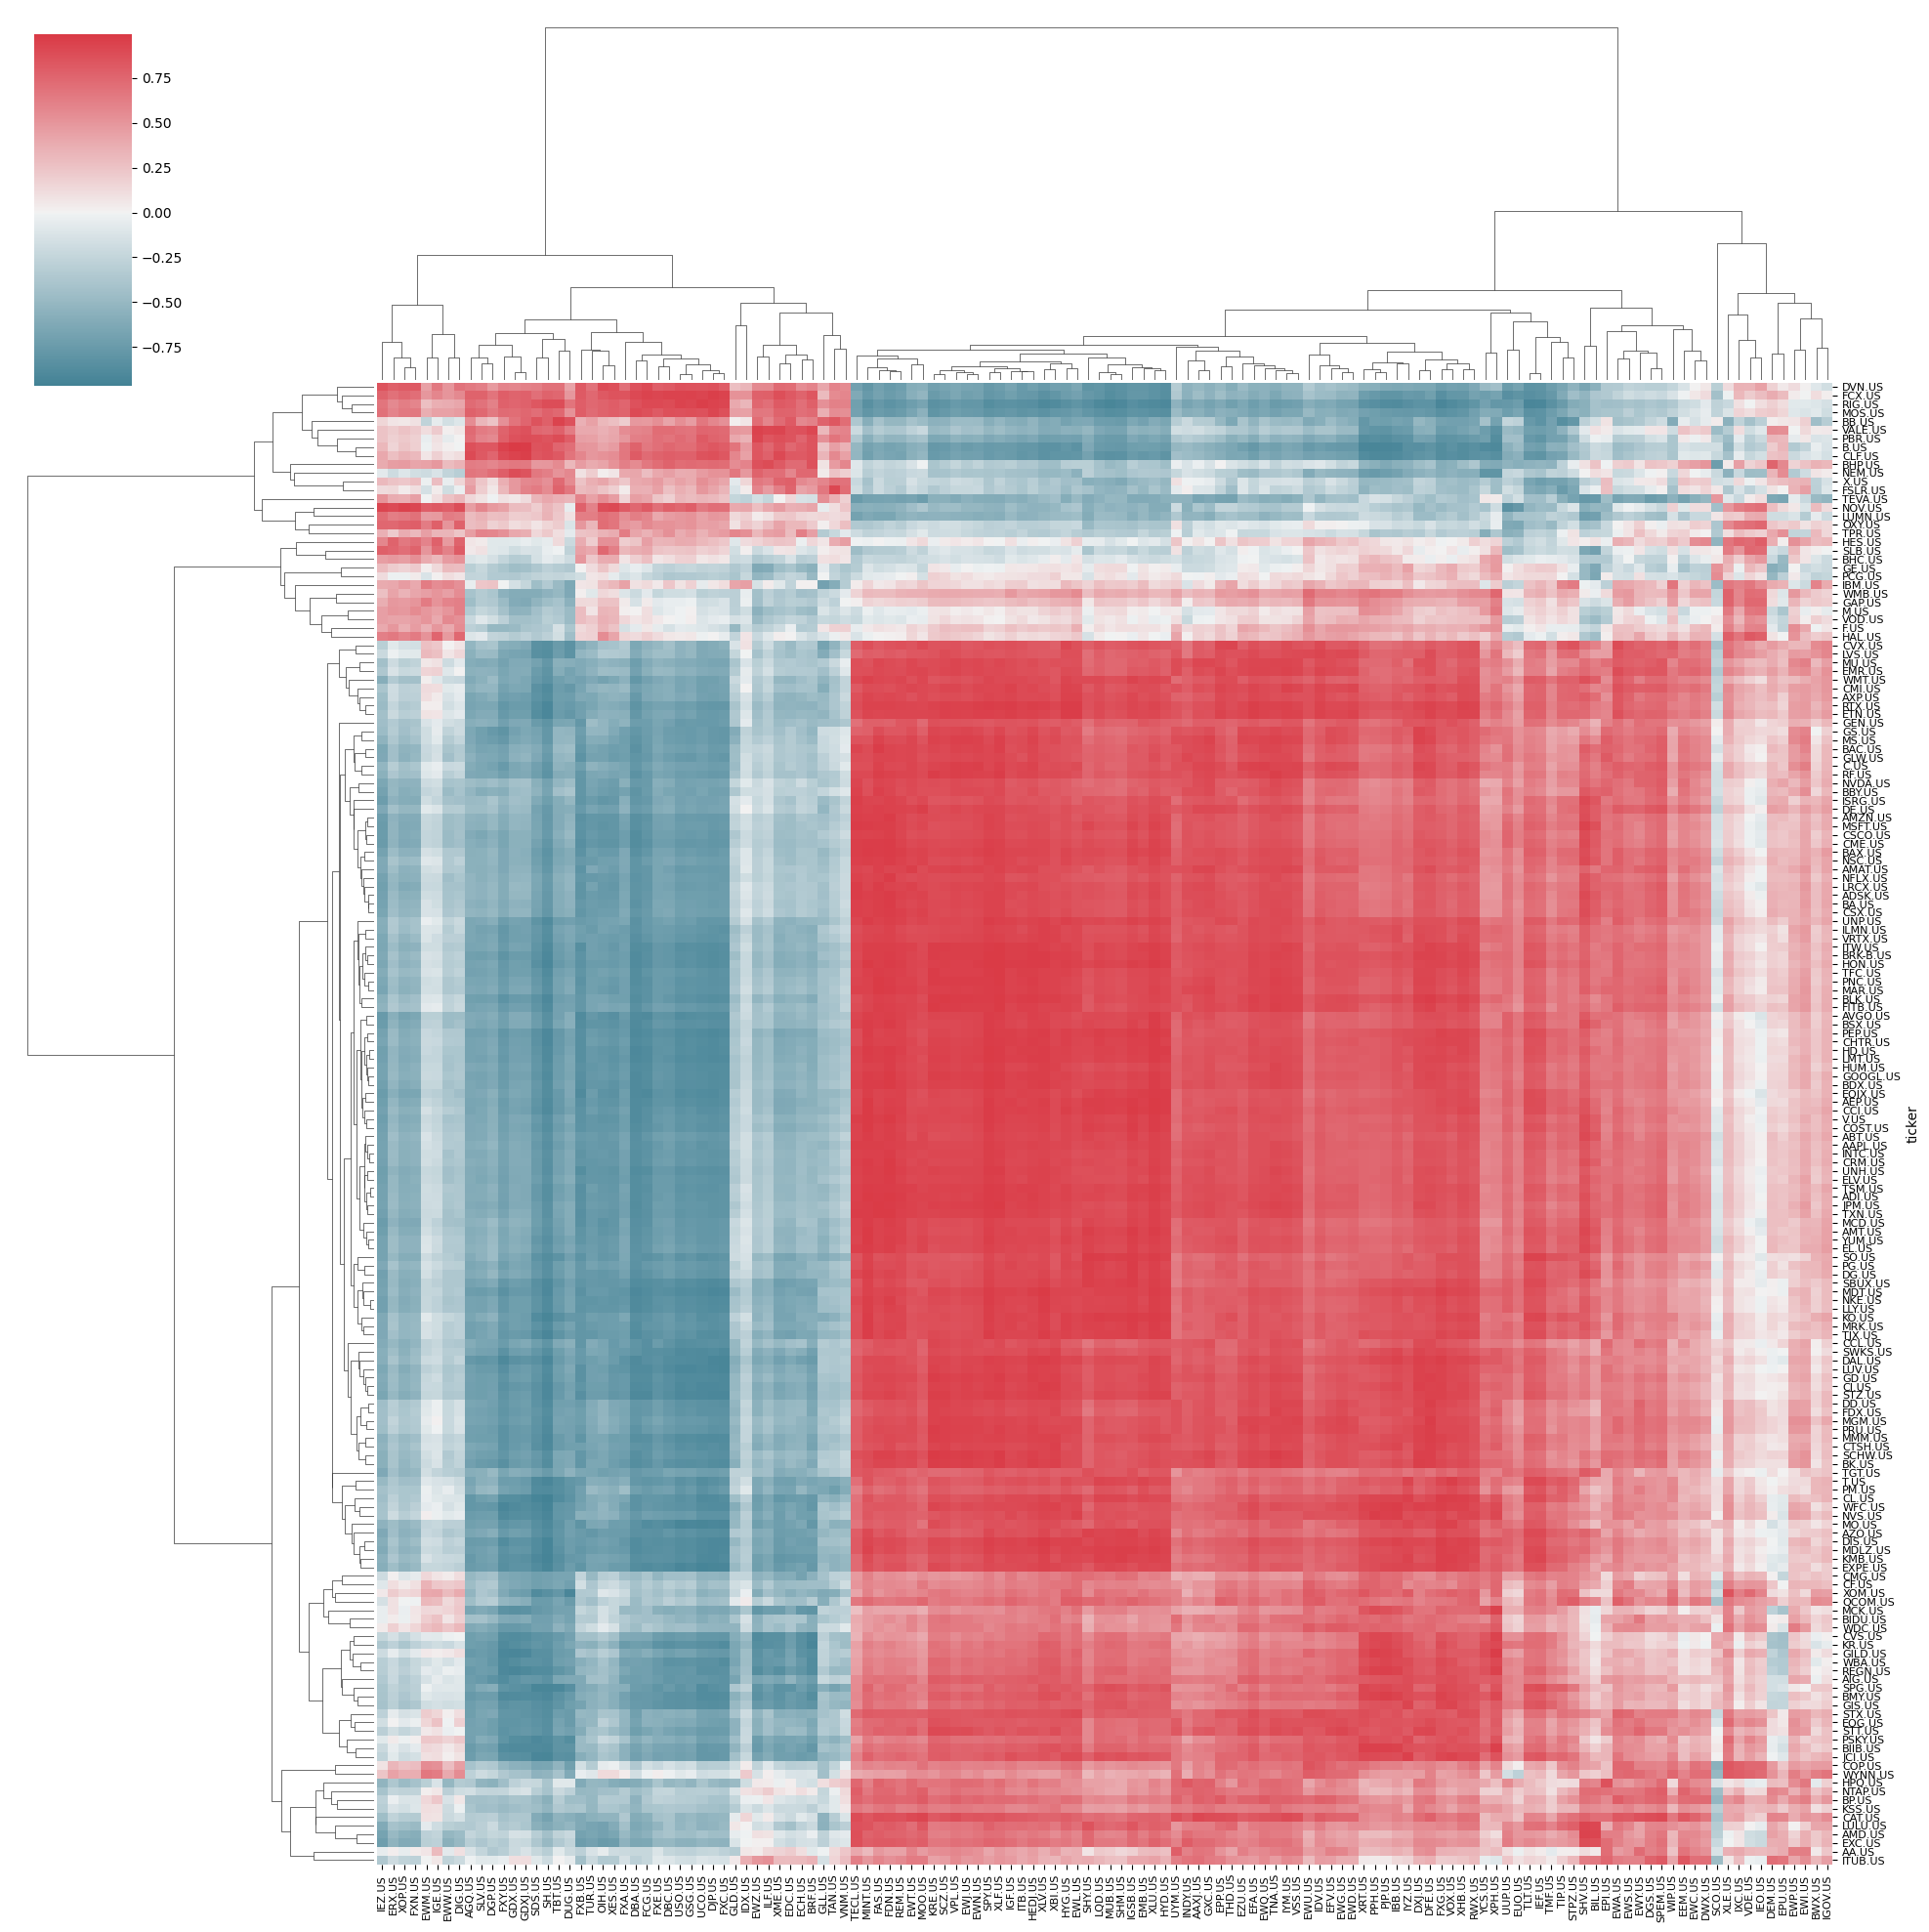

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt  # Ensure this is imported

cmap = sns.diverging_palette(220, 10, as_cmap=True)
fig = sns.clustermap(corr, cmap=cmap, center=0, xticklabels=True, yticklabels=True, figsize=(20, 20))  # Keep larger size for visibility

# Make x and y tick labels smaller (adjust labelsize as needed, e.g., 6 for very small)
fig.ax_heatmap.tick_params(axis='x', labelsize=8)
fig.ax_heatmap.tick_params(axis='y', labelsize=8)

# Optional: Rotate x labels for better fit if still crowded
fig.ax_heatmap.set_xticklabels(fig.ax_heatmap.get_xticklabels(), rotation=90)

# Save if needed for zooming
fig.savefig('clustermap_small_labels.png', dpi=300, bbox_inches='tight')

## Candidate Selection using Heuristics

### Computational Complexity: Comparing running times

In this section, we compare the running times of various cointegration tests. More specifically, we are running tests for a single asset vs. the remaining set of securities.

#### Prepare Data

In [23]:
stocks.info()
print(stocks.shape)
stocks

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Columns: 172 entries, AAPL.US to AEP.US
dtypes: float64(172)
memory usage: 3.3 MB
(2516, 172)


ticker,AAPL.US,AMZN.US,MSFT.US,BAC.US,GOOGL.US,NFLX.US,C.US,JPM.US,XOM.US,INTC.US,...,CLF.US,FITB.US,GEN.US,GAP.US,ADSK.US,FSLR.US,ADI.US,PCG.US,NVS.US,AEP.US
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,6.44,6.70,23.78,13.20,15.61,7.64,28.13,30.89,43.03,14.58,...,40.88,6.59,7.06,14.07,25.67,135.46,23.73,34.41,38.36,22.49
2010-01-05,6.45,6.73,23.79,13.63,15.54,7.36,29.21,31.49,43.20,14.57,...,41.51,6.77,7.02,14.25,25.28,137.40,23.69,34.03,38.33,22.23
2010-01-06,6.35,6.61,23.65,13.79,15.15,7.62,30.12,31.66,43.58,14.52,...,42.94,6.81,7.04,14.42,25.34,140.02,23.65,34.42,38.19,22.46
2010-01-07,6.34,6.50,23.40,14.25,14.80,7.49,30.20,32.29,43.44,14.38,...,42.29,7.22,7.03,13.89,25.48,140.48,23.46,33.83,37.85,22.65
2010-01-08,6.38,6.68,23.57,14.12,15.00,7.61,29.71,32.22,43.26,14.54,...,45.04,7.22,7.05,13.98,26.26,139.68,23.60,33.86,38.16,22.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,68.82,89.46,150.51,32.89,66.98,333.20,70.47,125.54,58.75,54.36,...,8.21,25.30,13.91,15.65,183.91,57.98,113.24,10.95,87.98,84.81
2019-12-26,70.19,93.44,151.78,33.17,67.88,332.63,71.58,126.87,58.85,54.73,...,8.17,25.43,13.79,15.90,184.24,58.66,113.25,10.86,87.97,84.85
2019-12-27,70.16,93.49,152.05,33.01,67.49,329.09,71.44,126.96,58.65,54.97,...,8.03,25.25,13.87,15.81,185.38,56.41,112.98,10.44,88.49,85.13


In [24]:
etfs.info()
print(etfs.shape)
etfs

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Columns: 132 entries, SPY.US to VNM.US
dtypes: float64(132)
memory usage: 2.6 MB
(2516, 132)


ticker,SPY.US,EEM.US,GLD.US,EFA.US,XLF.US,XLE.US,TLT.US,GDX.US,EWZ.US,HYG.US,...,EPU.US,WIP.US,PJP.US,INDY.US,XPH.US,STPZ.US,BRF.US,IDX.US,EWN.US,VNM.US
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,87.44,31.92,109.80,41.04,9.60,39.93,60.71,43.16,55.72,50.50,...,25.05,43.41,15.94,23.21,15.45,44.00,31.01,17.51,16.72,22.47
2010-01-05,87.67,32.15,109.70,41.08,9.77,40.25,61.11,43.58,55.78,50.74,...,25.45,43.53,15.84,23.36,15.36,44.09,30.66,17.81,16.72,22.97
2010-01-06,87.71,32.22,111.51,41.25,9.79,40.73,60.29,44.64,56.15,50.88,...,26.13,43.40,15.83,23.52,15.34,44.12,30.87,17.72,16.72,22.82
2010-01-07,88.10,32.03,110.82,41.09,10.00,40.67,60.39,44.42,55.53,51.09,...,26.16,43.32,15.85,23.60,15.38,44.13,30.41,17.70,16.62,22.80
2010-01-08,88.40,32.29,111.37,41.42,9.94,40.94,60.36,45.09,55.92,51.16,...,26.53,43.45,15.87,23.49,15.24,44.18,30.90,17.95,16.80,22.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,296.90,39.97,141.27,65.11,28.97,52.21,118.69,27.56,42.71,83.14,...,33.45,52.17,64.09,36.10,45.33,50.30,25.34,22.08,32.49,15.69
2019-12-26,298.48,40.25,142.38,65.39,29.13,52.19,118.98,27.96,43.65,83.27,...,33.85,52.33,63.68,35.91,45.14,50.36,25.87,22.17,32.69,15.71
2019-12-27,298.40,40.42,142.33,65.51,29.06,51.98,119.11,27.76,43.30,83.23,...,33.80,52.59,63.31,35.94,44.64,50.36,26.04,22.13,32.76,15.71


In [25]:
# etfs.iloc[:,].plot(figsize=(20, 6))
# plt.show()

2011-02-17  data corrupted

In [26]:
security = etfs['AAXJ.US'].loc['2012': '2015']
candidates = stocks.loc['2012': '2015']
# candidates = stocks.loc['2011-02-17': '2011-02-28']

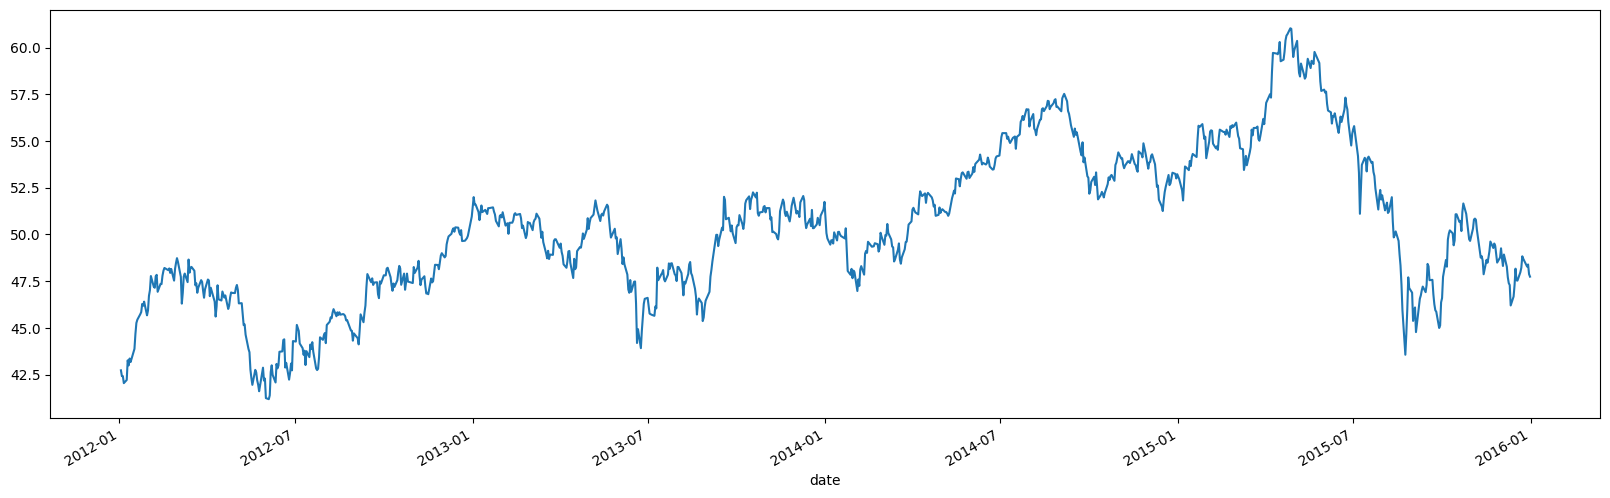

In [27]:
security.plot(figsize=(20, 6))
plt.show()

#### 1. Normalization of Price Series
```python
security = security.div(security.iloc[0])
candidates = candidates.div(candidates.iloc[0])
```
- **What it does**: Normalizes both the `security` (e.g., ETF prices) and `candidates` (e.g., stock prices) by dividing each series by its first value (`iloc[0]`). This scales all series to start at 1, making them comparable regardless of absolute price levels.
- **Why?**: In pairs trading, we care about relative movements, not absolute prices. Normalization helps compute meaningful spreads and correlations (e.g., avoiding bias from high-priced vs. low-priced assets).
- **Details**: `security` is a Series (one asset's prices over time). `candidates` is a DataFrame (multiple assets' prices, same time index). `ticker` extracts the name (e.g., ETF ticker) for later use in results.
- **Context from markdown**: This aligns with the "distance approach," where normalized prices are used to compute correlations or spreads for identifying comoving pairs.

In [28]:
print(security.iloc[0])
print(security)
security = security.div(security.iloc[0])
print("After scales all series to start at 1, making them comparable regardless of absolute price levels.")
print(security.describe())
security

42.7256
date
2012-01-03   42.73
2012-01-04   42.42
2012-01-05   42.42
2012-01-06   42.04
2012-01-09   42.21
              ... 
2015-12-24   48.70
2015-12-28   48.28
2015-12-29   48.39
2015-12-30   47.87
2015-12-31   47.74
Name: AAXJ.US, Length: 1006, dtype: float64
After scales all series to start at 1, making them comparable regardless of absolute price levels.
count   1,006.00
mean        1.18
std         0.09
min         0.96
25%         1.11
50%         1.17
75%         1.25
max         1.43
Name: AAXJ.US, dtype: float64


date
2012-01-03   1.00
2012-01-04   0.99
2012-01-05   0.99
2012-01-06   0.98
2012-01-09   0.99
             ... 
2015-12-24   1.14
2015-12-28   1.13
2015-12-29   1.13
2015-12-30   1.12
2015-12-31   1.12
Name: AAXJ.US, Length: 1006, dtype: float64

In [29]:
candidates.iloc[0]
candidates.head()

ticker,AAPL.US,AMZN.US,MSFT.US,BAC.US,GOOGL.US,NFLX.US,C.US,JPM.US,XOM.US,INTC.US,...,CLF.US,FITB.US,GEN.US,GAP.US,ADSK.US,FSLR.US,ADI.US,PCG.US,NVS.US,AEP.US
date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,12.38,8.95,21.11,4.90,16.57,10.32,23.46,25.74,54.51,17.59,...,56.35,8.72,6.05,13.02,30.81,35.79,27.74,32.96,42.42,27.24
2012-01-04,12.44,8.88,21.61,4.91,16.65,11.49,23.33,25.90,54.51,18.00,...,57.16,8.73,6.04,13.25,30.21,34.70,27.70,32.99,42.24,27.32
2012-01-05,12.58,8.88,21.84,5.34,16.42,11.33,23.61,26.44,54.35,18.20,...,56.81,8.98,6.06,12.82,30.82,35.48,27.82,33.15,41.90,27.35
2012-01-06,12.71,9.13,22.17,5.23,16.19,12.33,23.65,26.20,53.95,18.10,...,56.98,8.99,6.05,12.63,30.96,35.27,27.63,33.16,41.79,27.25
2012-01-09,12.69,8.93,21.89,5.30,15.51,14.03,24.09,26.16,54.19,18.25,...,56.62,8.95,6.01,12.67,31.08,36.84,28.18,33.15,41.56,27.38


In [30]:
candidates = candidates.div(candidates.iloc[0])
candidates

ticker,AAPL.US,AMZN.US,MSFT.US,BAC.US,GOOGL.US,NFLX.US,C.US,JPM.US,XOM.US,INTC.US,...,CLF.US,FITB.US,GEN.US,GAP.US,ADSK.US,FSLR.US,ADI.US,PCG.US,NVS.US,AEP.US
date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
2012-01-04,1.01,0.99,1.02,1.00,1.00,1.11,0.99,1.01,1.00,1.02,...,1.01,1.00,1.00,1.02,0.98,0.97,1.00,1.00,1.00,1.00
2012-01-05,1.02,0.99,1.03,1.09,0.99,1.10,1.01,1.03,1.00,1.03,...,1.01,1.03,1.00,0.98,1.00,0.99,1.00,1.01,0.99,1.00
2012-01-06,1.03,1.02,1.05,1.07,0.98,1.19,1.01,1.02,0.99,1.03,...,1.01,1.03,1.00,0.97,1.00,0.99,1.00,1.01,0.99,1.00
2012-01-09,1.03,1.00,1.04,1.08,0.94,1.36,1.03,1.02,0.99,1.04,...,1.00,1.03,0.99,0.97,1.01,1.03,1.02,1.01,0.98,1.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-24,1.98,3.70,2.33,3.06,2.30,11.37,1.87,2.13,1.04,1.63,...,0.03,1.72,1.42,1.48,2.01,1.87,1.77,1.54,1.66,1.69
2015-12-28,1.95,3.77,2.34,3.03,2.35,11.35,1.86,2.12,1.03,1.63,...,0.03,1.72,1.44,1.47,2.01,1.86,1.76,1.54,1.67,1.69
2015-12-29,1.99,3.88,2.36,3.06,2.39,11.54,1.88,2.14,1.04,1.65,...,0.03,1.73,1.46,1.50,2.02,1.86,1.79,1.55,1.69,1.70


#### 2. Compute Spreads

**Purpose:** 
- In pairs trading, the spread represents the relative deviation between two assets. For cointegrated pairs, the spread should be stationary (mean-reverting) rather than trending or random-walking. Low drift and volatility in the spread are heuristics for potential cointegration.

**How to read/understand the result:**

- Print spreads to see the DataFrame: Index is dates, columns are stock tickers, values are differences (e.g., 0.05 means the stock is 5% above the security at that date, assuming normalization).
- If the spread hovers around zero with small fluctuations, it suggests mean-reversion (good for trading). If it trends up/down, it has drift (less desirable).
- Example: If a spread starts near 0 (due to normalization) and ends at 0.2, the pair diverged; if it oscillates and returns to 0, it's potentially cointegrated.

In [31]:
spreads = candidates.sub(security, axis=0)
spreads

ticker,AAPL.US,AMZN.US,MSFT.US,BAC.US,GOOGL.US,NFLX.US,C.US,JPM.US,XOM.US,INTC.US,...,CLF.US,FITB.US,GEN.US,GAP.US,ADSK.US,FSLR.US,ADI.US,PCG.US,NVS.US,AEP.US
date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2012-01-04,0.01,-0.00,0.03,0.01,0.01,0.12,0.00,0.01,0.01,0.03,...,0.02,0.01,0.01,0.03,-0.01,-0.02,0.01,0.01,0.00,0.01
2012-01-05,0.02,-0.00,0.04,0.10,-0.00,0.10,0.01,0.03,0.00,0.04,...,0.02,0.04,0.01,-0.01,0.01,-0.00,0.01,0.01,-0.01,0.01
2012-01-06,0.04,0.04,0.07,0.08,-0.01,0.21,0.02,0.03,0.01,0.04,...,0.03,0.05,0.02,-0.01,0.02,0.00,0.01,0.02,0.00,0.02
2012-01-09,0.04,0.01,0.05,0.09,-0.05,0.37,0.04,0.03,0.01,0.05,...,0.02,0.04,0.01,-0.01,0.02,0.04,0.03,0.02,-0.01,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-24,0.84,2.56,1.19,1.92,1.16,10.23,0.73,0.99,-0.10,0.49,...,-1.11,0.59,0.28,0.34,0.87,0.73,0.63,0.40,0.52,0.55
2015-12-28,0.82,2.64,1.21,1.90,1.22,10.22,0.73,0.99,-0.10,0.50,...,-1.10,0.59,0.31,0.34,0.88,0.73,0.63,0.41,0.54,0.56
2015-12-29,0.85,2.74,1.23,1.93,1.25,10.41,0.75,1.01,-0.09,0.52,...,-1.10,0.60,0.32,0.37,0.89,0.72,0.65,0.41,0.56,0.57


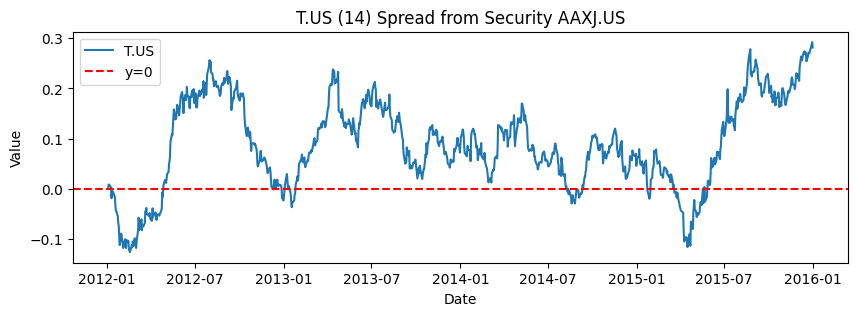

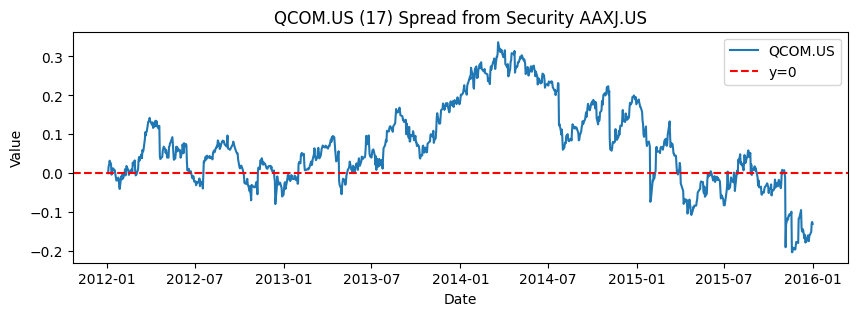

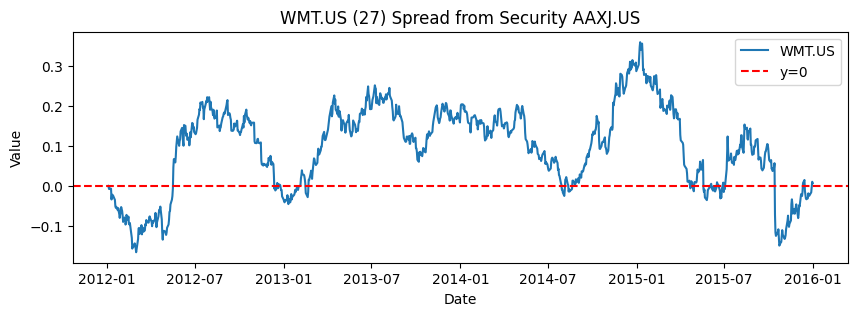

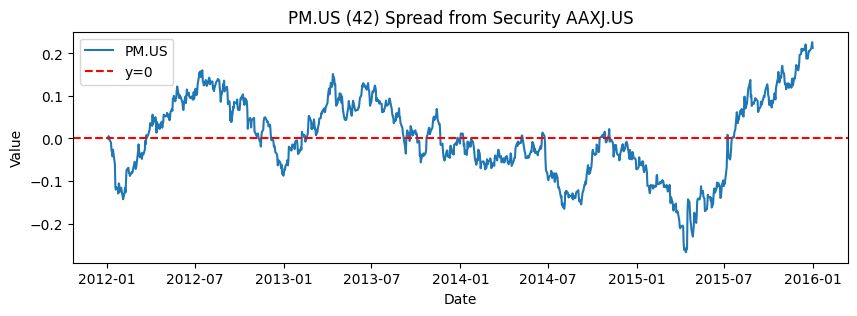

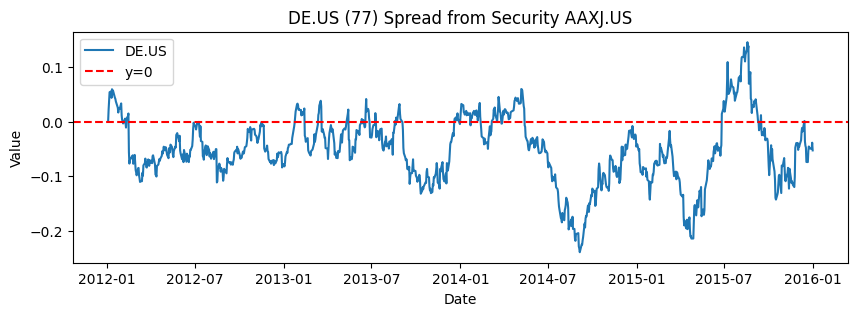

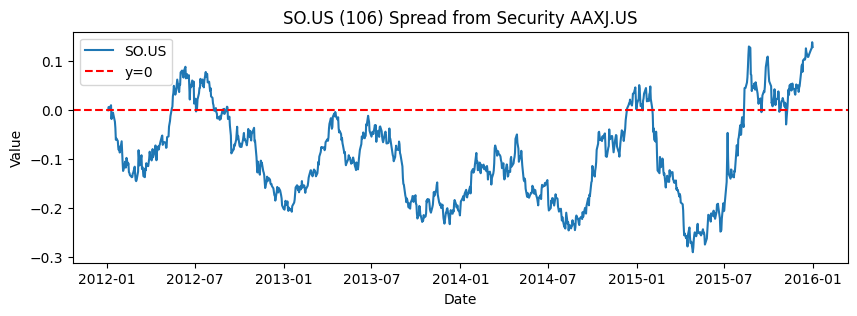

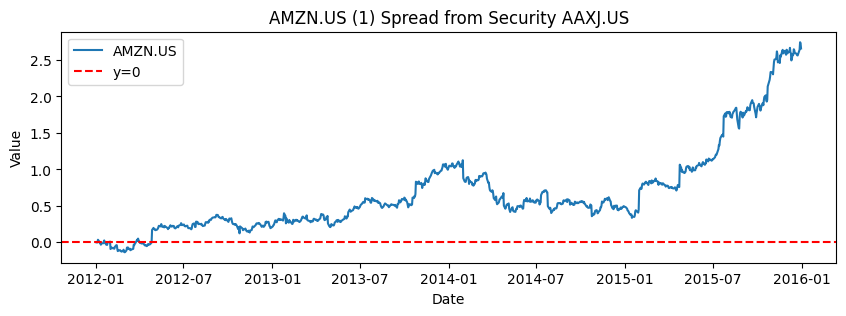

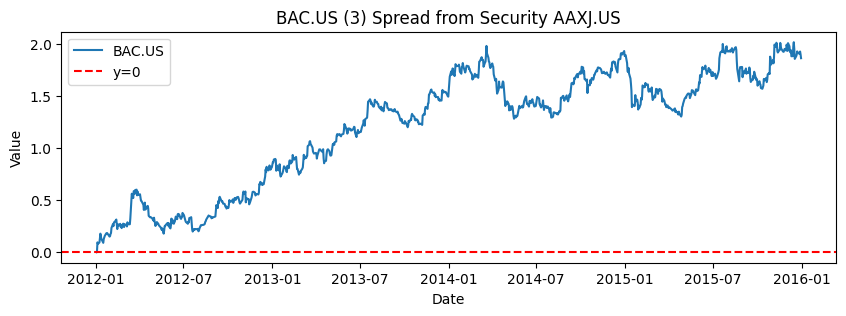

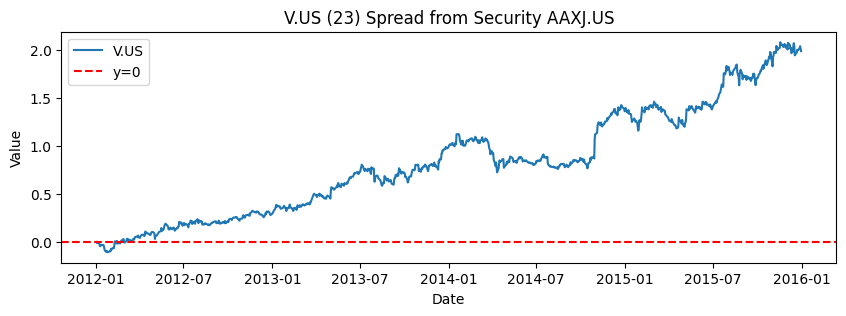

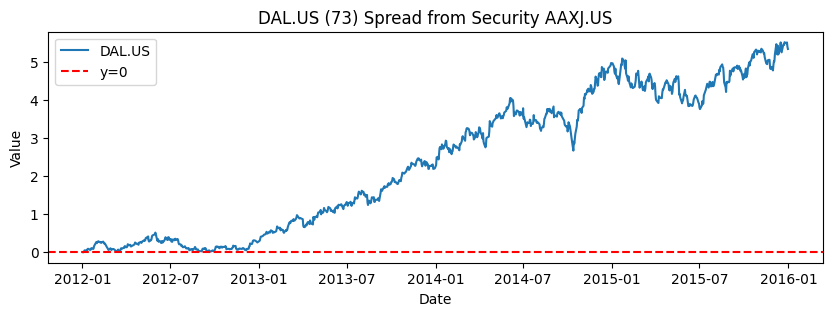

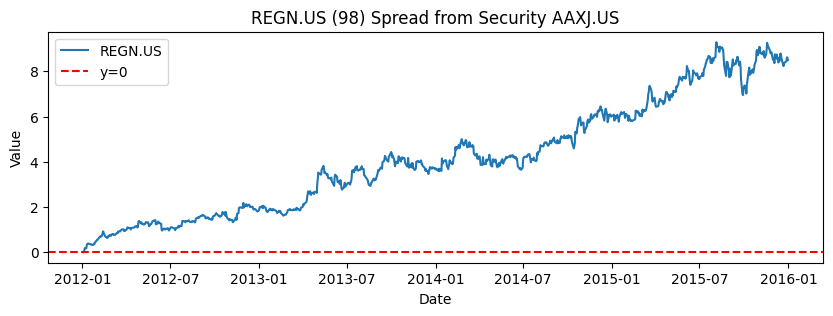

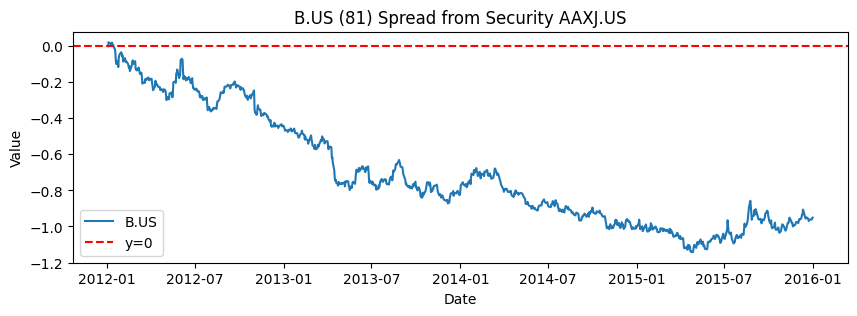

In [32]:
def plot_spread(spreads, security, ticker_index):
    # Create the figure
    fig = plt.figure()
    fig.set_figwidth(10)
    fig.set_figheight(3)

    # Plot the specified column of the spreads DataFrame
    plt.plot(spreads.index, spreads.iloc[:, ticker_index], label=f'{spreads.iloc[:, ticker_index].name}')

    # Draw a horizontal line at y=0
    plt.axhline(y=0, color='red', linestyle='--', label='y=0')

    # Add labels and legend for better visualization
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'{spreads.iloc[:, ticker_index].name} ({ticker_index}) Spread from Security {security.name}')
    plt.legend()
    plt.show()
    
mean_reverting_list = [14,17,27,42,77,106]
drift_list = [1,3,23,73,98,81]

# for i in range(spreads.shape[1]):
#     plot_spread(spreads, security, i)

for i in mean_reverting_list:
    plot_spread(spreads, security, i)
    
for i in drift_list:
    plot_spread(spreads, security, i)

In [33]:
n, m = spreads.shape
print(n,m)

1006 172


#### 3. Set Up Design Matrix for Drift Calculation.

- **What it is**: `X` is a numpy array (n rows x 2 columns) acting as the design matrix for ordinary least squares (OLS) regression.
  - Column 0: All 1s (intercept term).
  - Column 1: A time trend from 1 to n (linear sequence over the dates).
  - `n` is the number of time points (rows in `spreads`).
- **Purpose**: This sets up a simple linear regression model: spread_t = β0 + β1 * t + ε_t, where t is time. The slope β1 estimates the "drift" (average daily change in the spread). Low absolute drift indicates a stable, non-trending spread (heuristic for cointegration).
- **Output/Result**: A 2D array like `[[1, 1], [1, 2], ..., [1, n]]`.
- **How to read/understand the result**:
  - This isn't directly outputted, but it's used in the timed OLS below. The full regression (not shown here but in the full code) extracts β1 as drift for each spread column.
  - Interpret drift: If β1 ≈ 0, the spread is stable (good). If β1 = 0.001, the spread widens by 0.1% per period on average (bad for mean-reversion trading).
  - In context: Pairs with low |drift| (e.g., <0.0001) are prioritized for further testing.


In [34]:
X = np.ones(shape=(n, 2))
X[:, 1] = np.arange(1, n+1)

print(len(X))
X

1006


array([[1.000e+00, 1.000e+00],
       [1.000e+00, 2.000e+00],
       [1.000e+00, 3.000e+00],
       ...,
       [1.000e+00, 1.004e+03],
       [1.000e+00, 1.005e+03],
       [1.000e+00, 1.006e+03]])

#### Heuristics

#### 4. Compute Drift

Computes the ordinary least squares (OLS) regression coefficients for a simple linear regression model fitted independently to each column of the spreads DataFrame. It uses matrix algebra to solve for the coefficients in a vectorized way (efficient for multiple regressions at once, like across m candidate spreads).

2. **Derivation of the OLS Estimator**:
    - The least squares solution comes from setting the derivative of the error to zero (normal equations):  $X^T X \beta = X^T y$ .
    - Solve for β: Multiply both sides by the inverse of  $X^T X$ :

$\hat{\beta} = (X^T X)^{-1} X^T y$

https://www.youtube.com/watch?v=NN7mBupK-8o

In [35]:
# %%timeit
# np.linalg.inv(X.T @ X) @ X.T @ spreads

In [36]:
# Compute OLS coefficients
drift_result = np.linalg.inv(X.T @ X) @ X.T @ spreads

# Time the operation (mimicking %%timeit output)
import time
start = time.time()
np.linalg.inv(X.T @ X) @ X.T @ spreads
elapsed = time.time() - start
print(f"\nExecution time: {elapsed*1e6:.2f} µs")

# Print result
print("OLS Coefficients (β₀, β₁) for each spread:")
drift_result


Execution time: 3123.04 µs
OLS Coefficients (β₀, β₁) for each spread:


ticker,AAPL.US,AMZN.US,MSFT.US,BAC.US,GOOGL.US,NFLX.US,C.US,JPM.US,XOM.US,INTC.US,...,CLF.US,FITB.US,GEN.US,GAP.US,ADSK.US,FSLR.US,ADI.US,PCG.US,NVS.US,AEP.US
0,-0.04,-0.16,-0.15,0.35,-0.23,-1.39,0.09,-0.02,-0.03,-0.20,...,-0.25,0.01,0.07,0.64,-0.07,-0.36,-0.09,-0.11,-0.16,-0.14
1,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,-0.00,0.00,...,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


#### 5. Compute Volatility

In [37]:
# %%timeit
# spreads.std()

In [38]:
# Compute standard deviation
vol_result = spreads.std()

# Time the operation
start = time.time()
spreads.std()
elapsed = time.time() - start
print(f"\nExecution time: {elapsed*1e6:.2f} µs")

# Print result
print("Standard Deviation (Volatility) of each spread:")
vol_result


Execution time: 504.02 µs
Standard Deviation (Volatility) of each spread:


ticker
AAPL.US    0.37
AMZN.US    0.61
MSFT.US    0.31
BAC.US     0.55
GOOGL.US   0.35
           ... 
FSLR.US    0.39
ADI.US     0.23
PCG.US     0.15
NVS.US     0.27
AEP.US     0.18
Length: 172, dtype: float64

In [39]:
# %%timeit
# candidates.corrwith(security)

In [40]:
# Compute correlation
corr_result = candidates.corrwith(security)

# Time the operation
start = time.time()
candidates.corrwith(security)
elapsed = time.time() - start
print(f"\nExecution time: {elapsed*1e6:.2f} µs")

# Print result
print("Correlation between security and each candidate:")
corr_result


Execution time: 15139.10 µs
Correlation between security and each candidate:


ticker
AAPL.US    0.56
AMZN.US    0.30
MSFT.US    0.58
BAC.US     0.67
GOOGL.US   0.51
           ... 
FSLR.US    0.67
ADI.US     0.70
PCG.US     0.54
NVS.US     0.76
AEP.US     0.68
Length: 172, dtype: float64

In [41]:
# Transpose drift_result to shape (n, 2) and convert to DataFrame
drift_df = pd.DataFrame(drift_result.T.values, columns=['beta0', 'beta1'], index=vol_result.index)
combined_df = drift_df.assign(vol=vol_result, corr=corr_result)
combined_df


,beta0,beta1,vol,corr
ticker,,,,
AAPL.US,-0.04,0.00,0.37,0.56
AMZN.US,-0.16,0.00,0.61,0.30
MSFT.US,-0.15,0.00,0.31,0.58
BAC.US,0.35,0.00,0.55,0.67
GOOGL.US,-0.23,0.00,0.35,0.51
...,...,...,...,...
FSLR.US,-0.36,0.00,0.39,0.67
ADI.US,-0.09,0.00,0.23,0.70
PCG.US,-0.11,0.00,0.15,0.54


#### Cointegration Tests

2m 1.7s

In [42]:
# %%timeit
# for candidate, prices in candidates.items():
#     df = pd.DataFrame({'s1': security,
#                        's2': prices})
#     var = VAR(df.values)
#     lags = var.select_order()
#     k_ar_diff = lags.selected_orders['aic']
#     coint_johansen(df, det_order=0, k_ar_diff=k_ar_diff)
#     coint(security, prices, trend='c')[:2]
#     coint(prices, security, trend='c')[:2]

4.1s

**Data Preparation**
- Create `df = pd.DataFrame({'s1': security, 's2': prices})` for VAR/Johansen input.
- Context: Formats pair for vector models analyzing joint dynamics.

**VAR Fitting & Lag Selection**
- Fit `var = VAR(df.values)` on raw values for joint dependencies.
- Compute `lags = var.select_order()` using info criteria.
- Select `k_ar_diff = lags.selected_orders['aic']` (AIC balances fit/complexity).
- Context: Empirical lags for accurate testing; avoids bias in Johansen.

**Johansen Test**
- `cj = coint_johansen(df, det_order=0, k_ar_diff=k_ar_diff)`:
  - det_order=0: No trend in cointegrating relation.
  - Returns JohansenTestResult (eigenvalues, trace stats).
- Context: Detects cointegration vector(s); compare trace to critical values (e.g., reject no cointegration if trace0 > cv).

**Engle-Granger Tests**
- `eg1 = coint(security, prices, trend='c')[:2]`: Statistic/p-value for security ~ prices + const.
- `eg2 = coint(prices, security, trend='c')[:2]`: Reversed (prices ~ security + const).
- Context: Residual-based; checks stationarity via ADF. Bidirectional for asymmetry (lead-lag insights).

**Return**
- Tuple: (candidate, cj, eg1, eg2).
- Context: For aggregation; filter e.g., p<0.05 or trace > cv in trading pipeline.

In [43]:
from joblib import Parallel, delayed

def process_candidate(candidate, prices, security):
    df = pd.DataFrame({'s1': security, 's2': prices})
    var = VAR(df.values)
    lags = var.select_order()
    k_ar_diff = lags.selected_orders['aic']
    cj = coint_johansen(df, det_order=0, k_ar_diff=k_ar_diff)
    eg1 = coint(security, prices, trend='c')[:2]
    eg2 = coint(prices, security, trend='c')[:2]
    return candidate, cj, eg1, eg2

results = Parallel(n_jobs=-1)(
    delayed(process_candidate)(candidate, prices, security) for candidate, prices in candidates.items()
)

results_df = pd.DataFrame(results, columns=['candidate', 'johansen', 'eg1', 'eg2']).set_index('candidate')
results_df

,johansen,eg1,eg2
candidate,,,
AAPL.US,<statsmodels.tsa.vector_ar.vecm.JohansenTestRe...,"(-2.3650565397988115, 0.34157845184689506)","(-1.2067444263771443, 0.8561260620749584)"
AMZN.US,<statsmodels.tsa.vector_ar.vecm.JohansenTestRe...,"(-2.0856217318749506, 0.4838849145120905)","(1.7912668823986357, 1.0)"
MSFT.US,<statsmodels.tsa.vector_ar.vecm.JohansenTestRe...,"(-1.9368571039167048, 0.5612035762519096)","(0.23912694662742578, 0.9901477555797631)"
BAC.US,<statsmodels.tsa.vector_ar.vecm.JohansenTestRe...,"(-2.240769090339151, 0.4034501548061194)","(-1.5256609463330792, 0.7512212245353858)"
GOOGL.US,<statsmodels.tsa.vector_ar.vecm.JohansenTestRe...,"(-2.0498916577132857, 0.5025658228645784)","(0.40886892410373377, 0.9919647342767594)"
...,...,...,...
FSLR.US,<statsmodels.tsa.vector_ar.vecm.JohansenTestRe...,"(-2.748577635588323, 0.18259531815883312)","(-1.8424173660342995, 0.608899152091057)"
ADI.US,<statsmodels.tsa.vector_ar.vecm.JohansenTestRe...,"(-2.31700909178534, 0.36509681018514384)","(-1.381946506532306, 0.8036344544061713)"
PCG.US,<statsmodels.tsa.vector_ar.vecm.JohansenTestRe...,"(-2.238561898879029, 0.40457620244874437)","(-0.7995898364170816, 0.9347576639669881)"


In [44]:
# Extract trace statistics from Johansen results (lr1 attribute: [trace0, trace1])
trace_stats = pd.DataFrame(
    results_df['johansen'].apply(lambda res: res.lr1).tolist(),
    index=results_df.index,
    columns=['trace0', 'trace1']
)

# Note: JohansenTestResult does not have a 'pval' attribute in statsmodels 0.14+.
# Significance is determined by comparing trace stats to critical values (e.g., trace0 > 15.4943 at 95% level).
# Skip p-values extraction; use binary significance if needed.

# Extract Engle-Granger results (tuples: (t-stat, p-value))
eg_df = pd.DataFrame(
    results_df['eg1'].apply(pd.Series).add_prefix('eg1_').join(
        results_df['eg2'].apply(pd.Series).add_prefix('eg2_')
    ),
    index=results_df.index
)

# Rename columns: _0 to _tstat, _1 to _pvalue
eg_df = eg_df.rename(columns={
    'eg1_0': 'eg1_tstat',
    'eg1_1': 'eg1_pvalue',
    'eg2_0': 'eg2_tstat',
    'eg2_1': 'eg2_pvalue'
})

# Combine extracted values (without p-values)
extracted_df = pd.concat([trace_stats, eg_df], axis=1)

# Optional: Add significance flags using critical values from code
# trace0_cv = 15.4943  # 95% for rank 0
# trace1_cv = 3.8415   # 95% for rank 1
extracted_df['johansen_sig'] = (extracted_df['trace0'] > trace0_cv) & (extracted_df['trace1'] > trace1_cv)
extracted_df['eg1_sig'] = extracted_df['eg1_pvalue'] < 0.05  # p-value
extracted_df['eg2_sig'] = extracted_df['eg2_pvalue'] < 0.05  # p-value

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')  # 4 decimals for precision on p-values/stats
extracted_df

,trace0,trace1,eg1_tstat,eg1_pvalue,eg2_tstat,eg2_pvalue,johansen_sig,eg1_sig,eg2_sig
candidate,,,,,,,,,
AAPL.US,10.6594,2.6339,-2.3651,0.3416,-1.2067,0.8561,False,False,False
AMZN.US,9.9451,0.4275,-2.0856,0.4839,1.7913,1.0000,False,False,False
MSFT.US,7.8451,0.0543,-1.9369,0.5612,0.2391,0.9901,False,False,False
BAC.US,12.5025,5.2263,-2.2408,0.4035,-1.5257,0.7512,False,False,False
GOOGL.US,7.3368,0.0006,-2.0499,0.5026,0.4089,0.9920,False,False,False
...,...,...,...,...,...,...,...,...,...
FSLR.US,10.7273,1.8266,-2.7486,0.1826,-1.8424,0.6089,False,False,False
ADI.US,9.4593,2.3625,-2.3170,0.3651,-1.3819,0.8036,False,False,False
PCG.US,7.4570,0.8517,-2.2386,0.4046,-0.7996,0.9348,False,False,False


Clearly, cointegration tests are significantly more costly. It would be great if the heuristics worked just as well, or at least 'good enough'.

### Compute Heuristics

The function `compute_pair_metrics()` computes the following distance metrics for over 23,000 pairs of
stocks and Exchange Traded Funds (ETFs) for 2010-14 and 2015-19:

- The **drift of the spread**, defined as a linear regression of a time trend on the spread
- The spread's  **volatility**
- The **correlations** between the normalized price series and between their returns

Low drift and volatility, as well as high correlation, are simple proxies for cointegration. 

To evaluate the predictive power of these heuristics, we also run Engle-Granger and Johansen **cointegration tests** using `statsmodels` for the preceding pairs. This takes place in the loop in the second half of `compute_pair_metrics()`.

We first estimate the optimal number of lags that we need to specify for the Johansen test. For both tests, we assume that the cointegrated series (the spread) may have an intercept different from zero but no trend:

**Normalization & Spreads**
- Normalize `security` and `candidates` by dividing by first value (relative scaling).
- Extract `ticker = security.name`.
- Compute spreads: `candidates - security` (axis=0).
- Dimensions: `n` (time steps), `m` (candidates).
- OLS design: `X = [ones, 1 to n]`.

**Drift (Vectorized OLS)**
- Regress spreads on time trend: $β = (X'X)^{-1} X'$ spreads.
- Drift = $β[1]$ (slope) as DataFrame 'drift'.
- Purpose: Measures spread trend; low |drift| ≈ stable mean-reversion (cointegration proxy).
- Efficient: Vectorized over columns; index=candidate tickers.
- Context: Screens before costly tests.

**Volatility (Vectorized)**
- `vol = spreads.std()` (ddof=1) as DataFrame.
- Purpose: Spread volatility for trading signals; balanced with low drift for cointegration heuristic.
- Context: Cointegrated pairs show ~2x volatility vs. distance pairs (e.g., Huck & Afawubo 2015).

**Correlations (Vectorized)**
- Return corr: `candidates.pct_change().corrwith(security.pct_change())` as 'corr_ret'.
  - Purpose: Daily comovement; high corr as heuristic, but ≠ cointegration.
- Price corr: `candidates.corrwith(security)` as 'corr'.

**Parallel Tests**
- Per-pair `process_candidate`:
  - Pair DataFrame: {'s1': security, 's2': candidate}.
  - VAR lag selection: AIC (`k_ar_diff`).
  - Johansen: `coint_johansen` (det=0).
  - Engle-Granger: `coint` (trend='c') both directions (t1/p1, t2/p2).
  - Return: [ticker, candidate, t1, p1, t2, p2, k_ar_diff, trace0, trace1].
- Parallel: `joblib.Parallel(n_jobs=-1)` over candidates.
- `tests` DataFrame, index='s2'.

**Output**
- `metrics.join(tests)`: Heuristics + cointegration stats for pair screening.

**Notes**
- Efficiency: Vectorized heuristics; parallel tests (adjust n_jobs if needed).
- Usage: Filter low drift/vol, high corr, p<0.05.
- Context: Pairs trading pipeline; reduces candidates pre-tests.

6m 40s

In [45]:
from joblib import Parallel, delayed

def compute_pair_metrics(security, candidates):
    security = security.div(security.iloc[0])
    ticker = security.name 
    candidates = candidates.div(candidates.iloc[0])
    spreads = candidates.sub(security, axis=0)
    n, m = spreads.shape
    X = np.ones(shape=(n, 2))
    X[:, 1] = np.arange(1, n + 1)
    
    drift = ((np.linalg.inv(X.T @ X) @ X.T @ spreads).iloc[1].to_frame('drift'))
    
    vol = spreads.std().to_frame('vol')
    
    corr_ret = (candidates.pct_change().corrwith(security.pct_change()).to_frame('corr_ret'))
    
    corr = candidates.corrwith(security).to_frame('corr')
    metrics = drift.join(vol).join(corr).join(corr_ret).assign(n=n)
    
    def process_candidate(candidate, prices):
        df = pd.DataFrame({'s1': security, 's2': prices})
        var = VAR(df.values)
        lags = var.select_order()  
        k_ar_diff = lags.selected_orders['aic']
        cj0 = coint_johansen(df, det_order=0, k_ar_diff=k_ar_diff)
        t1, p1 = coint(security, prices, trend='c')[:2]
        t2, p2 = coint(prices, security, trend='c')[:2]
        return [ticker, candidate, t1, p1, t2, p2, k_ar_diff, *cj0.lr1]
    
    tests = Parallel(n_jobs=-1)(
        delayed(process_candidate)(candidate, prices) 
        for candidate, prices in candidates.items()
    )
    
    columns = ['s1', 's2', 't1', 'p1', 't2', 'p2', 'k_ar_diff', 'trace0', 'trace1']
    tests = pd.DataFrame(tests, columns=columns).set_index('s2')
    return metrics.join(tests)

In [46]:
# Outer loop remains the same, but now inner is parallelized
spreads = []
start = 2010
stop = 2019
etf_candidates = etfs.loc[str(start): str(stop), :]
stock_candidates = stocks.loc[str(start): str(stop), :]
s = time.time()
for i, (etf_ticker, etf_prices) in enumerate(etf_candidates.items(), 1):
    df = compute_pair_metrics(etf_prices, stock_candidates)
    spreads.append(df.set_index('s1', append=True))
    if i % 10 == 0:
        print(f'\n{i:>3} {time.time() - s:.1f}\n')
        s = time.time()


 10 33.6


 20 34.6


 30 35.8


 40 36.2


 50 35.4


 60 35.2


 70 34.9


 80 34.6


 90 34.1


100 36.8


110 34.0


120 33.8


130 33.5



In [47]:
# def compute_pair_metrics(security, candidates):
#     security = security.div(security.iloc[0])
#     ticker = security.name
#     candidates = candidates.div(candidates.iloc[0])
#     spreads = candidates.sub(security, axis=0)
#     n, m = spreads.shape
#     X = np.ones(shape=(n, 2))
#     X[:, 1] = np.arange(1, n + 1)
    
#     # compute drift
#     drift = ((np.linalg.inv(X.T @ X) @ X.T @ spreads).iloc[1]
#              .to_frame('drift'))
    
#     # compute volatility
#     vol = spreads.std().to_frame('vol')
    
#     # return correlation
#     corr_ret = (candidates.pct_change()
#                 .corrwith(security.pct_change())
#                 .to_frame('corr_ret'))
    
#     # normalized price series correlation
#     corr = candidates.corrwith(security).to_frame('corr')
#     metrics = drift.join(vol).join(corr).join(corr_ret).assign(n=n)
    
#     tests = []
#     # run cointegration tests
#     for candidate, prices in tqdm(candidates.items()):
#         df = pd.DataFrame({'s1': security, 's2': prices})
#         var = VAR(df.values)
#         lags = var.select_order() # select VAR order
#         k_ar_diff = lags.selected_orders['aic']
#         # Johansen Test with constant Term and estd. lag order
#         cj0 = coint_johansen(df, det_order=0, k_ar_diff=k_ar_diff)
#         # Engle-Granger Tests
#         t1, p1 = coint(security, prices, trend='c')[:2]
#         t2, p2 = coint(prices, security, trend='c')[:2]
#         tests.append([ticker, candidate, t1, p1, t2, p2, 
#                       k_ar_diff, *cj0.lr1])
#     columns = ['s1', 's2', 't1', 'p1', 't2', 'p2', 'k_ar_diff', 'trace0', 'trace1']
#     tests = pd.DataFrame(tests, columns=columns).set_index('s2')
#     return metrics.join(tests)

In [48]:
# spreads = []
# start = 2010
# stop = 2019
# etf_candidates = etfs.loc[str(start): str(stop), :]
# stock_candidates = stocks.loc[str(start): str(stop), :]
# s = time()
# for i, (etf_ticker, etf_prices) in enumerate(etf_candidates.items(), 1):
#     df = compute_pair_metrics(etf_prices, stock_candidates)
#     spreads.append(df.set_index('s1', append=True))
#     if i % 10 == 0:
#         print(f'\n{i:>3} {time() - s:.1f}\n')
#         s = time()

## Overview
This code is from a pairs trading workflow using Stooq data (via HDF5). It identifies cointegrated ETF-stock pairs for mean-reverting spreads. Process: Load/filter assets by volume, correlation, stationarity; compute heuristics (drift, vol, corr); run Johansen/Engle-Granger tests; aggregate into `spreads` DataFrame (~46,000 pairs).

The snippet concatenates per-ETF results, reorganizes index, adds names, and derives summary stats for analysis (e.g., heuristic evaluation, pair selection).

## Step-by-Step Breakdown

- **`names = get_ticker_dict()`**  
  Loads dict mapping tickers (e.g., 'AAPL.US') to names (e.g., 'Apple Inc.') from Stooq HDF5. Used for readable outputs. Context: Prepares for naming in aggregated DataFrame.

- **`spreads = pd.concat(spreads)`**  
  Merges list of per-ETF DataFrames (metrics vs. stocks) into one (~125,000 rows pre-filter, ~46,000 final). Columns: heuristics (`drift`, `vol`, `corr`, `corr_ret`, `n`); tests (`t1`, `p1`, `t2`, `p2`, `k_ar_diff`, `trace0`, `trace1`). MultiIndex: stocks ('s2') outer, ETFs ('s1') inner. Unifies for global analysis.

- **`spreads.index.names = ['s2', 's1']`**  
  Labels MultiIndex levels for clarity ('s2': stocks, 's1': ETFs). Prepares for swapping.

- **`spreads = spreads.swaplevel()`**  
  Flips levels: ETFs ('s1') outer, stocks ('s2') inner. Aligns with ETF-as-reference convention for grouping/plotting.

- **`spreads['name1'] = spreads.index.get_level_values('s1').map(names)`**  
  Maps ETF tickers ('s1') to names, adds column 'name1' (e.g., 'SPDR S&P 500 ETF Trust'). Enhances readability.

- **`spreads['name2'] = spreads.index.get_level_values('s2').map(names)`**  
  Maps stock tickers ('s2') to names, adds 'name2' (e.g., 'Apple Inc.'). Provides symmetric pair descriptions.

- **`spreads['t'] = spreads[['t1', 't2']].min(axis=1)`**  
  Min of Engle-Granger t-stats ('t1': ETF~stock, 't2': stock~ETF). Selects stronger (more negative) evidence of cointegration.

- **`spreads['p'] = spreads[['p1', 'p2']].min(axis=1)`**  
  Min of p-values. Selects more significant direction for thresholding (e.g., <0.05 flags cointegration).

In [49]:
names = get_ticker_dict() #Output: names is a dict like {'AAPL.US': 'Apple Inc.', 'SPY.US': 'SPDR S&P 500 ETF Trust', ...}.
spreads = pd.concat(spreads)
spreads.index.names = ['s2', 's1']
spreads = spreads.swaplevel()
spreads['name1'] = spreads.index.get_level_values('s1').map(names)
spreads['name2'] = spreads.index.get_level_values('s2').map(names)

In [ ]:
spreads['t'] = spreads[['t1', 't2']].min(axis=1)
spreads['p'] = spreads[['p1', 'p2']].min(axis=1)

In [ ]:
# Save (add after spreads['p'] = ...)
spreads.to_hdf('spreads_data.h5', key='spreads', mode='w', complevel=9, complib='blosc')

In [ ]:
# Load in future (in a new script/session)
spreads = pd.read_hdf('spreads_data.h5', key='spreads')

In [79]:
spreads

,s1,s2,drift,vol,corr,corr_ret,n,t1,p1,t2,...,k_ar_diff,trace0,trace1,name1,name2,t,p,trace_sig,eg_sig,coint
0,SPY.US,AAPL.US,0.19%,152.82%,96.24%,12.78%,2516,-170.97%,67.25%,-119.34%,...,9,594.33%,31.24%,SPDR S&P 500 ETF TRUST,APPLE INC,-170.97%,67.25%,0,0,0
1,SPY.US,AMZN.US,0.45%,371.26%,93.47%,13.58%,2516,-170.56%,67.44%,-168.09%,...,9,523.20%,37.60%,SPDR S&P 500 ETF TRUST,AMAZON.COM INC,-170.56%,67.44%,0,0,0
2,SPY.US,MSFT.US,0.08%,81.47%,93.97%,16.85%,2516,-132.42%,82.23%,-18.56%,...,9,2870.83%,96.02%,SPDR S&P 500 ETF TRUST,MICROSOFT CORP,-132.42%,82.23%,0,0,0
3,SPY.US,BAC.US,0.03%,28.67%,91.37%,15.96%,2516,-289.67%,13.68%,-267.17%,...,9,877.81%,12.99%,SPDR S&P 500 ETF TRUST,BANK OF AMERICA CORP,-289.67%,13.68%,0,0,0
4,SPY.US,GOOGL.US,0.05%,40.62%,98.30%,14.24%,2516,-357.67%,2.62%,-355.85%,...,12,1234.27%,93.03%,SPDR S&P 500 ETF TRUST,ALPHABET INC,-357.67%,2.62%,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22699,VNM.US,FSLR.US,0.01%,18.59%,71.49%,18.87%,2516,-372.20%,1.72%,-288.62%,...,7,2231.39%,593.18%,VANECK VIETNAM ETF,FIRST SOLAR INC,-372.20%,1.72%,1,1,1
22700,VNM.US,ADI.US,0.15%,110.17%,-31.57%,32.98%,2516,-337.88%,4.48%,-38.02%,...,3,1132.61%,5.41%,VANECK VIETNAM ETF,ANALOG DEVICES INC,-337.88%,4.48%,0,1,0
22701,VNM.US,PCG.US,0.01%,43.86%,-33.05%,6.56%,2516,-334.83%,4.84%,-121.11%,...,5,1266.94%,61.34%,VANECK VIETNAM ETF,PG&E CORP,-334.83%,4.84%,0,1,0
22702,VNM.US,NVS.US,0.06%,45.68%,-30.20%,29.14%,2516,-329.30%,5.57%,-126.99%,...,5,1239.32%,105.28%,VANECK VIETNAM ETF,NOVARTIS AG,-329.30%,5.57%,0,0,0


### Engle-Granger vs Johansen: how do their findings compare?

To check for the significance of the cointegration tests, we compare the Johansen trace statistic for rank 0 and 1 to their respective critical values and obtain the Engle-Granger p-value.

We follow the recommendation by Gonzalo and Lee (1998) to apply both tests and accept pairs where they agree. The authors suggest additional due diligence in case of disagreement, which we are going to skip.

In [52]:
spreads['trace_sig'] = ((spreads.trace0 > trace0_cv) &
                        (spreads.trace1 > trace1_cv)).astype(int)
spreads['eg_sig'] = (spreads.p < .05).astype(int)

For the over 46,000 pairs across both sample periods, the Johansen test considers 3.2 percent of the relationships as significant, while the Engle-Granger considers 6.5 percent. They agree on 183 pairs (results may change with new data downloaded from stooq).

In [53]:
pd.crosstab(spreads.eg_sig, spreads.trace_sig)

trace_sig,0,1
eg_sig,,
0,20339,702
1,1480,183


In [54]:
spreads['coint'] = (spreads.trace_sig & spreads.eg_sig).astype(int)

In [55]:
spreads.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 22704 entries, ('SPY.US', 'AAPL.US') to ('VNM.US', 'AEP.US')
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   drift      22704 non-null  float64
 1   vol        22704 non-null  float64
 2   corr       22704 non-null  float64
 3   corr_ret   22704 non-null  float64
 4   n          22704 non-null  int64  
 5   t1         22704 non-null  float64
 6   p1         22704 non-null  float64
 7   t2         22704 non-null  float64
 8   p2         22704 non-null  float64
 9   k_ar_diff  22704 non-null  int64  
 10  trace0     22704 non-null  float64
 11  trace1     22704 non-null  float64
 12  name1      22704 non-null  object 
 13  name2      22704 non-null  object 
 14  t          22704 non-null  float64
 15  p          22704 non-null  float64
 16  trace_sig  22704 non-null  int64  
 17  eg_sig     22704 non-null  int64  
 18  coint      22704 non-null  int64  
dtypes: float64(

In [56]:
spreads = spreads.reset_index()
spreads

,s1,s2,drift,vol,corr,corr_ret,n,t1,p1,t2,...,k_ar_diff,trace0,trace1,name1,name2,t,p,trace_sig,eg_sig,coint
0,SPY.US,AAPL.US,0.0019,1.5282,0.9624,0.1278,2516,-1.7097,0.6725,-1.1934,...,9,5.9433,0.3124,SPDR S&P 500 ETF TRUST,APPLE INC,-1.7097,0.6725,0,0,0
1,SPY.US,AMZN.US,0.0045,3.7126,0.9347,0.1358,2516,-1.7056,0.6744,-1.6809,...,9,5.2320,0.3760,SPDR S&P 500 ETF TRUST,AMAZON.COM INC,-1.7056,0.6744,0,0,0
2,SPY.US,MSFT.US,0.0008,0.8147,0.9397,0.1685,2516,-1.3242,0.8223,-0.1856,...,9,28.7083,0.9602,SPDR S&P 500 ETF TRUST,MICROSOFT CORP,-1.3242,0.8223,0,0,0
3,SPY.US,BAC.US,-0.0003,0.2867,0.9137,0.1596,2516,-2.8967,0.1368,-2.6717,...,9,8.7781,0.1299,SPDR S&P 500 ETF TRUST,BANK OF AMERICA CORP,-2.8967,0.1368,0,0,0
4,SPY.US,GOOGL.US,0.0005,0.4062,0.9830,0.1424,2516,-3.5767,0.0262,-3.5585,...,12,12.3427,0.9303,SPDR S&P 500 ETF TRUST,ALPHABET INC,-3.5767,0.0262,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22699,VNM.US,FSLR.US,-0.0001,0.1859,0.7149,0.1887,2516,-3.7220,0.0172,-2.8862,...,7,22.3139,5.9318,VANECK VIETNAM ETF,FIRST SOLAR INC,-3.7220,0.0172,1,1,1
22700,VNM.US,ADI.US,0.0015,1.1017,-0.3157,0.3298,2516,-3.3788,0.0448,-0.3802,...,3,11.3261,0.0541,VANECK VIETNAM ETF,ANALOG DEVICES INC,-3.3788,0.0448,0,1,0
22701,VNM.US,PCG.US,0.0001,0.4386,-0.3305,0.0656,2516,-3.3483,0.0484,-1.2111,...,5,12.6694,0.6134,VANECK VIETNAM ETF,PG&E CORP,-3.3483,0.0484,0,1,0
22702,VNM.US,NVS.US,0.0006,0.4568,-0.3020,0.2914,2516,-3.2930,0.0557,-1.2699,...,5,12.3932,1.0528,VANECK VIETNAM ETF,NOVARTIS AG,-3.2930,0.0557,0,0,0


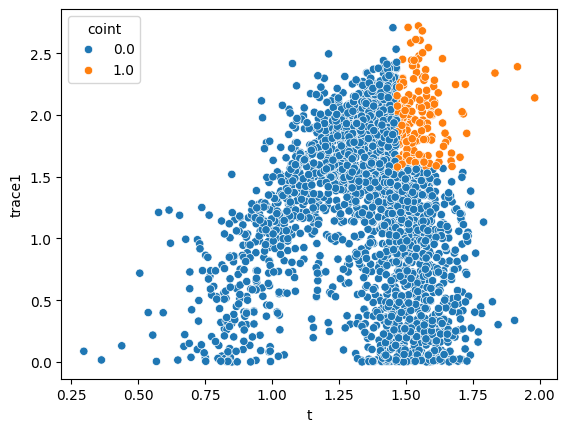

In [57]:
sns.scatterplot(x=np.log1p(spreads.t.abs()), 
                y=np.log1p(spreads.trace1), 
                hue='coint', data=spreads[spreads.trace0>trace0_cv]);

In [58]:
spreads.to_hdf('heuristics.h5', 'spreads')

/var/folders/lb/ycbntly138n0xkt0fdrnnk_w0000gn/T/ipykernel_25297/2263100903.py:1: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  spreads.to_hdf('heuristics.h5', 'spreads')


In [59]:
spreads = pd.read_hdf('heuristics.h5', 'spreads')

### Evaluate Heuristics

In [60]:
spreads.drift = spreads.drift.abs()

In [61]:
pd.crosstab(spreads.eg_sig, spreads.trace_sig)

trace_sig,0,1
eg_sig,,
0,20339,702
1,1480,183


In [62]:
pd.set_option('display.float_format', lambda x: f'{x:.2%}')
pd.crosstab(spreads.eg_sig, spreads.trace_sig, normalize=True)

trace_sig,0,1
eg_sig,,
0,89.58%,3.09%
1,6.52%,0.81%


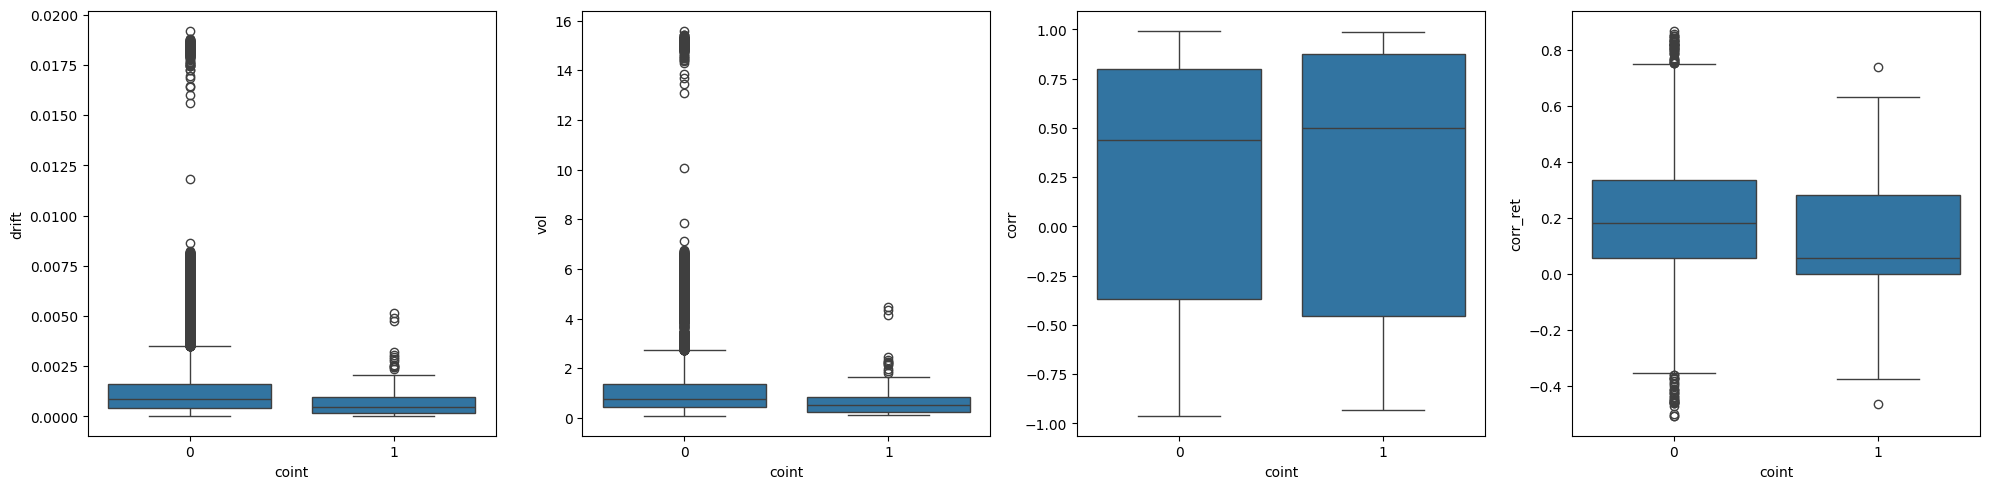

In [63]:
fig, axes = plt.subplots(ncols=4, figsize=(20, 5))
for i, heuristic in enumerate(['drift', 'vol', 'corr', 'corr_ret']):
    sns.boxplot(x='coint', y=heuristic, data=spreads, ax=axes[i])
fig.tight_layout();

### How well do the heuristics predict significant cointegration?

When we compare the distributions of the heuristics for series that are cointegrated according to both tests with the remainder that is not, volatility and drift are indeed lower (in absolute terms). Figure 9.14 shows that the picture is less clear for the two correlation measures:

In [64]:
spreads.groupby(spreads.coint)[['drift', 'vol', 'corr']].describe().stack(level=0).swaplevel().sort_index()

/var/folders/lb/ycbntly138n0xkt0fdrnnk_w0000gn/T/ipykernel_25297/3967601492.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  spreads.groupby(spreads.coint)[['drift', 'vol', 'corr']].describe().stack(level=0).swaplevel().sort_index()


count    mean     std     min     25%    50%     75%  \
      coint                                                              
corr  0     2252100.00%  23.24%  61.33% -96.43% -37.07% 43.89%  79.96%   
      1       18300.00%  23.29%  69.00% -93.41% -45.49% 50.14%  87.37%   
drift 0     2252100.00%   0.13%   0.18%   0.00%   0.04%  0.09%   0.16%   
      1       18300.00%   0.08%   0.09%   0.00%   0.02%  0.05%   0.10%   
vol   0     2252100.00% 116.21% 147.88%   5.92%  43.81% 76.59% 135.46%   
      1       18300.00%  70.75%  69.45%  10.14%  25.33% 53.60%  82.62%   

                 max  
      coint           
corr  0       99.43%  
      1       98.83%  
drift 0        1.92%  
      1        0.51%  
vol   0     1559.97%  
      1      446.41%

In [65]:
spreads.coint.value_counts()

coint
0    22521
1      183
Name: count, dtype: int64

#### Logistic Regression

To evaluate the predictive accuracy of the heuristics, we first run a logistic regression model with these features to predict significant cointegration. It achieves an area-under-the-curve (AUC) cross-validation score of 0.815; excluding the correlation metrics, it still scores 0.804. A decision tree does slightly better at AUC=0.821, with or without the correlation features.

In [66]:
y = spreads.coint
X = spreads[['drift', 'vol', 'corr', 'corr_ret']]
# X = spreads[['drift', 'vol']]

In [67]:
kf = StratifiedKFold(n_splits=5, shuffle=True)

In [68]:
log_reg = LogisticRegressionCV(Cs=np.logspace(-10, 10, 21), 
                               class_weight='balanced',
                               scoring='roc_auc')

'C:-9.00, AUC: 61.81%'

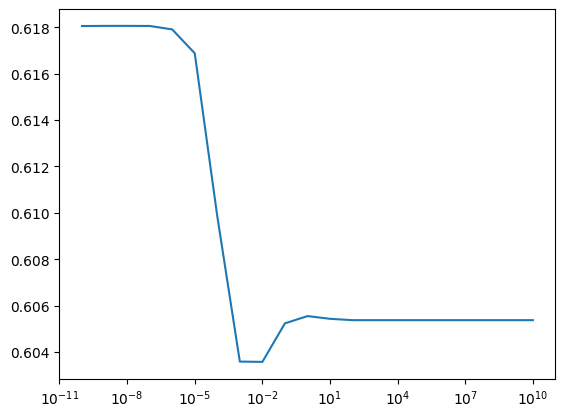

In [69]:
log_reg.fit(X=X, y=y)
Cs = log_reg.Cs_
scores = pd.DataFrame(log_reg.scores_[True], columns=Cs).mean()
scores.plot(logx=True);
f'C:{np.log10(scores.idxmax()):.2f}, AUC: {scores.max():.2%}'

In [70]:
log_reg.coef_

array([[-3.06858097e-09, -2.58028233e-06,  2.87980794e-09,
        -3.33399290e-07]])

In [71]:
y_pred = log_reg.predict_proba(X)[:, 1]
confusion_matrix(y_true=spreads.coint, y_pred=(y_pred>.5))

array([[22521,     0],
       [  183,     0]])

In [72]:
spreads.assign(y_pred=log_reg.predict_proba(X)[:, 1]).groupby(spreads.coint).y_pred.describe()

,count,mean,std,min,25%,50%,75%,max
coint,,,,,,,,
0,2252100.00%,50.00%,0.00%,50.00%,50.00%,50.00%,50.00%,50.00%
1,18300.00%,50.00%,0.00%,50.00%,50.00%,50.00%,50.00%,50.00%


Not least due to the strong class imbalance, there are large numbers of false positives:
correctly identifying 80 percent of the 366 cointegrated pairs implies over 16,500 false positives, but eliminates almost 30,000 of the candidates. See the notebook cointegration_
tests for additional detail.

The **key takeaway** is that distance heuristics can help screen a large universe more  efficiently, but this comes at a cost of missing some cointegrated pairs and still requires
substantial testing.

#### Decision Tree Classifier

In [73]:
model = DecisionTreeClassifier(class_weight='balanced')
decision_tree = GridSearchCV(model,
                             param_grid={'max_depth': list(range(1, 10))},
                             cv=5,
                             scoring='roc_auc')

In [74]:
decision_tree.fit(X=X, y=y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(class_weight='balanced'),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='roc_auc')

In [75]:
f'{decision_tree.best_score_:.2%}, Depth: {decision_tree.best_params_["max_depth"]}'

'65.74%, Depth: 3'

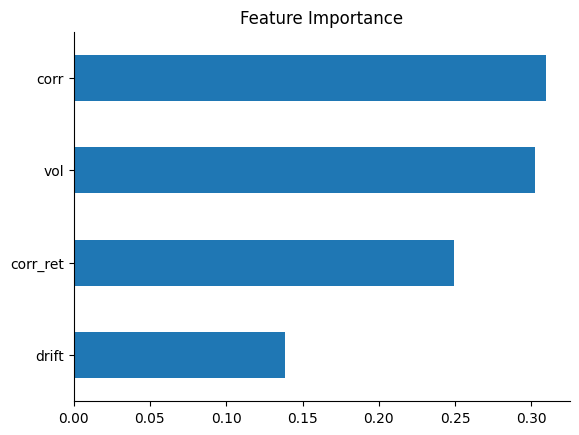

In [76]:
pd.Series(data=decision_tree.best_estimator_.feature_importances_, 
          index=X.columns).sort_values().plot.barh(title='Feature Importance')
sns.despine();

In [77]:
spreads.assign(y_pred=decision_tree.predict_proba(X)[:, 1]).groupby(spreads.coint).y_pred.describe()

,count,mean,std,min,25%,50%,75%,max
coint,,,,,,,,
0,2252100.00%,35.31%,19.67%,0.00%,25.87%,25.87%,25.87%,96.36%
1,18300.00%,64.69%,25.58%,23.89%,25.87%,68.30%,80.61%,96.36%


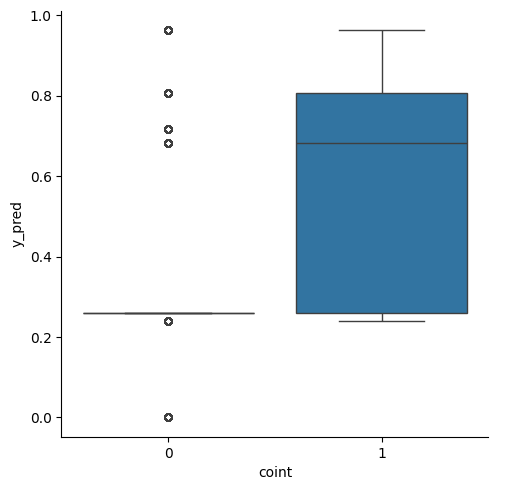

In [78]:
sns.catplot(x='coint', 
            y='y_pred', 
            data=spreads.assign(y_pred=decision_tree.predict_proba(X)[:, 1]), 
            kind='box');